In [2]:
%matplotlib_svg
import numpy as np
from matplotlib import pyplot as plt
from sympy import *
%init_sympy_printing

## 机械运动模拟

### 推导系统的微分方程

In [3]:
from sympy.physics.mechanics import *
I = ReferenceFrame('I')                # 定义惯性参照系
O = Point('O')                         # 定义原点
O.set_vel(I, 0)                        # 设置点O在参照系I中的速度为0
g = symbols("g")

> **LINK**

> http://www.pydy.org/

> 本节只介绍`mechanics`模块最基本的用法，若读者对使用SymPy求解多刚体系统感兴趣，可以参考PyDy扩展库。

In [4]:
q = dynamicsymbols("q")
u = dynamicsymbols("u")
m1 = symbols("m1")
P1 = Point('P1')                    
P1.set_pos(O, q * I.x)              # 点P1的位置相对于点O，沿着参照系I的X轴偏移q
P1.set_vel(I, u * I.x)              # 点P1在参照系I中的速度为X轴方向，大小为u
box = Particle('box', P1, m1)       # 在点P1处放置质量为m1的方块box

In [5]:
%sympy_latex q, u

<IPython.core.display.Latex object>

In [6]:
th = dynamicsymbols("theta")
w  = dynamicsymbols("omega")
B = I.orientnew('B', 'Axis', [th, I.z])  # 将I围绕Z轴旋转theta得到参照系B
B.set_ang_vel(I, w * I.z)                # 设置B的角速度

In [7]:
l, m2 = symbols("l,m2")
P2 = P1.locatenew('P2', -l * B.y)  # P2相对于P1沿着B的Y轴负方向偏移l
P2.v2pt_theory(P1, I, B)           # 使用二点理论设置P2在I中的速度
ball = Particle('ball', P2, m2)    # 在P2处放置质量为m2的小球 

In [8]:
P2.vel(I) #显示P2在I中的速度

In [8]:
eqs = [q.diff() - u, th.diff() - w] #q的导数为u，th的导数为w
kane = KanesMethod(I, q_ind=[q, th], u_ind=[u, w], kd_eqs=eqs)

In [9]:
particles = [box, ball]  #系统包含的所有质点
forces = [(P1, -m1*g*I.y), (P2, -m2*g*I.y)] #系统所受的外力
fr, frstar = kane.kanes_equations(forces, particles)

In [10]:
%sympy_latex Eq(fr[0] + frstar[0], 0)
%sympy_latex Eq(fr[1] + frstar[1], 0)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [18]:
from IPython import display
status = Matrix([[q],[th],[u],[w]])
display.Math(latex(kane.mass_matrix_full) + latex(status.diff()) + 
             "=" + latex(kane.forcing_full))

<IPython.core.display.Math object>

### 将符号表达式转换为程序

In [19]:
diff_status = kane.mass_matrix_full.inv() * kane.forcing_full

In [20]:
from sympy.utilities.autowrap import autowrap
status_symbols = [Symbol(sym.func.__name__) for sym in status] #❶
expr = diff_status.subs(list(zip(status, status_symbols))) #❷

_func_diff_status = autowrap(expr, args=[m1, m2, l, g] + status_symbols, tempdir=r".\tmp_mechanics") #❸

In [21]:
def func_diff_status(status, t, m1, m2, l, g):
    q, th, u, w = status
    return _func_diff_status(m1, m2, l, g, q, th, u, w).ravel()

init_status = np.array([0, np.deg2rad(45), 0, 0])
args = 1.0, 2.0, 1.0, 9.8
func_diff_status(init_status, 0, *args)

array([  0.        ,   0.        ,   4.9       , -10.39446968])

In [22]:
#%hide
%matplotlib_svg

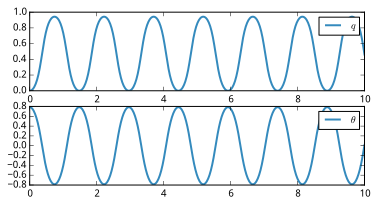

In [23]:
#%fig=使用`odeint()`计算的运动轨迹
from scipy.integrate import odeint

t = np.linspace(0, 10, 500)
res = odeint(func_diff_status, init_status, t, args=args)

fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(t, res[:, 0], label="$q$")
ax1.legend()
ax2.plot(t, res[:, 1], label="$\\theta$")
ax2.legend();

### 动画演示

In [24]:
from matplotlib import animation
from matplotlib.patches import Rectangle, Circle
from matplotlib.lines import Line2D

def animate_system(t, states, blit=True):
    q, th, u, w = states.T
    fig = plt.figure()
    w, h = 0.2, 0.1
    ax = plt.axes(xlim=(-0.5, 1.5), ylim=(-1.5, 0.5), aspect='equal')

    rect = Rectangle([q[0], 0,  - w / 2.0, - h / 2],
        w, h, fill=True, color='red', ec='black', axes=ax, animated=blit)
    ax.add_patch(rect)
    
    line = Line2D([], [], lw=2, marker='o', markersize=6, animated=blit, axes=ax)
    ax.add_artist(line)
    
    circle = Circle((0, 0), 0.1, axes=ax, animated=blit)
    ax.add_patch(circle)

    def animate(i):
        x1, y1 = q[i], 0
        l = 1.0
        x2, y2 = l*sin(th[i]) + x1, -l*cos(th[i]) + y1
        rect.set_xy((x1-w*0.5, y1))
        line.set_data([x1, x2], [y1, y2])
        circle.center = x2, y2
        return rect, line, circle
    
    anim = animation.FuncAnimation(fig, animate, frames=len(t),
            interval=t[-1] / len(t) * 1000, blit=blit, repeat=False)
        
    return anim

In [27]:
%gui qt
%matplotlib qt
anim = animate_system(t, res);